# Sampling tweets

- Only English and German tweets.
- Character limit 50
- 

In [1]:
import sys
sys.path.append("../..")

import numpy as np
import dask.dataframe as dd
import pyarrow.parquet as pq
import pandas as pd

from pathlib import Path
from bld.project_paths import project_paths_join as ppj

In [53]:
df = pd.read_pickle(ppj("OUT_DATA", "data_clean.pkl"))

In [54]:
def replace_urls(df):
    """Replace urls in tweets with token.
    
    We replace urls in the tweets with the token `[URL]` and do the following two steps.
    
    1. Use the urls scraped with the tweets and replace them.
    2. Use a generic regex to remove other urls
    
    The url regex is taken from http://www.urlregex.com/.
    
    """
    url_not_na = df.urls.notna()
    df.loc[url_not_na, "text"] = df.loc[url_not_na].apply(lambda x: x.text.replace(x.urls, "[URL]"), axis=1)
    
    url_regex = r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+"
    df.text = df.text.str.replace(url_regex, "[URL]")
    
    return df


def replace_mentions(df):
    """Replace mentions in tweets with token.
    
    Use the mentions scraped with the tweet and replace them.
    
    After this process, there are still @<whatever> expressions in the tweets which look like
    the users wanted to use hashtags instead. But, only for less than 3% of tweets.
    
    """
    def _replace_mentions_row(row):
        for mention in row.mentions.split(" "):
            row.text = row.text.replace(mention, "[MNT]")
        return row
    
    mention_not_na = df.mentions.notna()
    df.loc[mention_not_na, "text"] = df.loc[mention_not_na].apply(
        lambda x: _replace_mentions_row(x), axis=1
    )
    
    return df

In [55]:
df = replace_urls(df)

In [56]:
df = replace_mentions(df)

In [111]:
df.shape

(31713, 12)

In [110]:
df.loc[df.text.str.endswith("... [URL]")]

,username,to,text,retweets,favorites,replies,permalink,author_id,date,hashtags,mentions,urls
id,,,,,,,,,,,,
1238398657575223296,Vallisblog,NaN,VALLIS BLOG: Kampf gegen Corona: International...,0,0,0,https://twitter.com/Vallisblog/status/12383986...,20895633,2020-03-13 09:37:02+00:00,NaN,NaN,https://vallisblog.blogspot.com/2020/03/kampf-...
1238346813238726656,pairsonnalitesN,NaN,Stigmabase — Großevents wegen Corona untersagt...,1,0,0,https://twitter.com/pairsonnalitesN/status/123...,191092262,2020-03-13 06:11:02+00:00,NaN,NaN,http://dlvr.it/RRnlHv
1240891078368055296,pairsonnalitesN,NaN,Stigmabase — Coronavirus und Armut: Wie geht e...,1,0,0,https://twitter.com/pairsonnalitesN/status/124...,191092262,2020-03-20 06:41:02+00:00,NaN,NaN,http://dlvr.it/RSDD5T
1240876104346267648,pairsonnalitesN,NaN,Stigmabase — Armutskonferenz will Corona-Schut...,2,0,0,https://twitter.com/pairsonnalitesN/status/124...,191092262,2020-03-20 05:41:32+00:00,NaN,NaN,http://dlvr.it/RSD7C3
1242900486719787009,Skandalzeitung,NaN,Neues zum Corona-Wahnsinn in Auaburg! Wohin mi...,0,0,0,https://twitter.com/Skandalzeitung/status/1242...,386108018,2020-03-25 19:45:42+00:00,NaN,NaN,https://augsburger-skandal-zeitung.blogspot.co...
...,...,...,...,...,...,...,...,...,...,...,...,...
1242393854520639488,wo_saarland,NaN,Drive-in-Teststation im Regionalverband: SAARB...,0,0,0,https://twitter.com/wo_saarland/status/1242393...,256015523,2020-03-24 10:12:32+00:00,NaN,NaN,http://dlvr.it/RSSCqJ
1241167651256360961,wo_saarland,NaN,Wegen Corona-Krise: Appell an Vermieter und Ku...,0,0,0,https://twitter.com/wo_saarland/status/1241167...,256015523,2020-03-21 01:00:02+00:00,NaN,NaN,http://dlvr.it/RSH1Wh
1240804509137252353,wo_saarland,NaN,Corona-Infos in Fremdsprachen: SAARBRÜCKEN Die...,1,0,0,https://twitter.com/wo_saarland/status/1240804...,256015523,2020-03-20 00:57:02+00:00,NaN,NaN,http://dlvr.it/RSChSk


In [109]:
df.loc[df.text.str.len().gt(40) & df.text.str.len().lt(60)].iloc[6].permalink

'https://twitter.com/FreieWaehlerKoe/status/1238538378397835266'

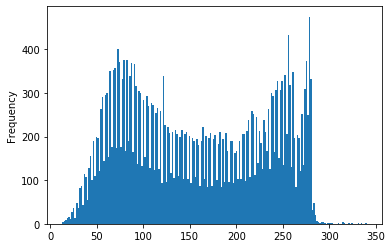

In [78]:
df.text.str.len().plot.hist(bins=200)

In [105]:
df.text.loc[df.text.str.len().eq(13)]

id
1239169304672829440    wegen corona?
1237438267555020802    Wegen Corona?
Name: text, dtype: object

In [104]:
df.text.str.len().min()

13